In [1]:
import jax
import jax.numpy as jnp
import bayes3d as b
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os

In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/


### Solve Bundle Adjustment

In [3]:
def pixel_reconstruction(structure, posevec, intrinsics):
    pose = b.t3d.transform_from_posevec(posevec)
    reconstruction = b.project_cloud_to_pixels(b.t3d.apply_transform(structure, b.t3d.inverse_pose(pose)), intrinsics)
    return reconstruction

def loss(structure, posevecs, intrinsics, obs_pixels):
    return ((jax.vmap(pixel_reconstruction, in_axes=(None, 0, None))(structure, posevecs, intrinsics) - obs_pixels)**2).mean()

loss_jit = jax.jit(loss)

gradient_structure_func_jit = jax.jit(jax.grad(loss, argnums=0))
grad_poses_func_jit = jax.jit(jax.grad(loss, argnums=1))

In [4]:
# --- creating the ycb dir from the working directory
bop_ycb_dir = os.path.join(b.utils.get_assets_dir(), "bop/ycbv")
rgbd, gt_ids, gt_poses, masks = b.utils.ycb_loader.get_test_img('52', '1', bop_ycb_dir)

intrinsics = b.Intrinsics(
    rgbd.intrinsics.height, rgbd.intrinsics.width,
    rgbd.intrinsics.fx, rgbd.intrinsics.fx,
    rgbd.intrinsics.width/2, rgbd.intrinsics.height/2,
    rgbd.intrinsics.near, rgbd.intrinsics.far
)

In [5]:
data_file = "tapir_50z_point_tracks.npz"
data = np.load(data_file, allow_pickle=True)
tracks = data['tracks']
visibles = data['visibles']

print(tracks.shape)
print(visibles.shape)
print(tracks[:,0,:])

(256, 100, 2)
(256, 100)
[[  4.38260883   3.46883588]
 [ 42.65480995   2.55936764]
 [ 86.03710175   2.84463845]
 [128.77671242   2.33877674]
 [170.40876389   2.24865966]
 [212.37024307   2.4490618 ]
 [255.27685165   2.0321741 ]
 [297.27827072   2.74201043]
 [342.10056305   2.45461956]
 [386.47380829   2.34720692]
 [427.92720795   2.54420735]
 [470.85865021   1.68424509]
 [512.61585236   1.06569964]
 [555.3521347    2.65353978]
 [597.08026886   2.77670883]
 [635.2192688    2.51498289]
 [  3.62883955  32.06643462]
 [ 41.91692352  32.26988196]
 [ 84.50042725  31.96251512]
 [127.60638237  31.9474268 ]
 [169.72805023  32.07492113]
 [211.90822601  32.22378731]
 [254.43729401  31.90273762]
 [297.34586716  31.68420553]
 [342.74490356  31.58616543]
 [385.55580139  32.06988931]
 [427.56816864  31.96109891]
 [469.9111557   32.12754965]
 [512.12146759  32.08176613]
 [554.29714203  32.44662523]
 [596.81808472  32.30476856]
 [636.43123627  30.79467058]
 [  3.65736693  62.9519105 ]
 [ 42.19857693  64

In [6]:
tracks.shape

(256, 100, 2)

In [9]:
K = jnp.array([
    [intrinsics.fx, 0.0, intrinsics.cx],
    [0.0, intrinsics.fy,  intrinsics.cy],
    [0.0, 0.0, 1.0],
])

pixels_1 = tracks[:,0,:]


b.clear()
for i in range(2,5,5):
    pixels_2 = tracks[:,i,:]

    E, _ = cv2.findEssentialMat(np.array(pixels_1), np.array(pixels_2), np.array(K))

    points, R, t, mask = cv2.recoverPose(E, np.array(pixels_1), np.array(pixels_2), np.array(K), 10000.0)

    baseline_transform = b.t3d.inverse_pose(b.t3d.transform_from_rot_and_pos(R,t))

    P_0 = K @ jnp.hstack([jnp.eye(3), jnp.zeros((3,1))])
    P_1 = K @ jnp.hstack([R, t.reshape(-1,1)])

    in_1 = np.array(pixels_1).transpose()
    in_2 = np.array(pixels_2).transpose()
    points_homogenous = cv2.triangulatePoints(
        np.array(P_0), np.array(P_1), np.array(pixels_1).transpose(), np.array(pixels_2).transpose()
    ).transpose()
    points_3d = points_homogenous[:,:3] / points_homogenous[:,3].reshape(-1,1)

    b.show_pose(str(i), baseline_transform)
    print(jnp.abs(pixel_reconstruction(points_3d, b.t3d.transform_to_posevec(jnp.eye(4)),intrinsics) - pixels_1).sum()) #transform_to_posevec_j
    print(jnp.abs(pixel_reconstruction(points_3d, b.t3d.transform_to_posevec(baseline_transform),intrinsics) - pixels_2).sum())

#centroid1 = jnp.mean(points_3d, axis=0) 


b.show_cloud("structure", points_3d)
b.show_pose("1", jnp.eye(4))


147.09125
144.66472


In [27]:
def render_point_light(pose_vec, structure):#, intrinsics):
    pose = b.t3d.transform_from_posevec(pose_vec)
    inv_pose = b.t3d.inverse_pose(pose)

    #calculate centroid and subtract from both poses

    image = b.render_point_cloud(b.t3d.apply_transform(structure, inv_pose), intrinsics, pixel_smudge=0.5)

    #need to center the point cloud back at origin
    
    return image #, r_image

gpus = jax.devices('gpu')
#render_point_light_parallel_jit = jax.jit(jax.vmap(render_point_light, in_axes=(0,0)))

In [28]:
# oo = render_point_light(b.t3d.transform_to_posevec(baseline_transform), points_3d)
oo = render_point_light(b.t3d.transform_to_posevec(jnp.eye(4)), points_3d)

In [29]:
oo

Array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

<Figure size 640x480 with 0 Axes>

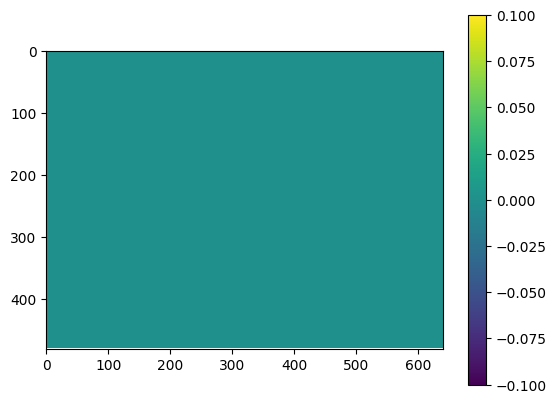

<Figure size 640x480 with 0 Axes>

In [30]:
plt.imshow(jnp.any(oo,axis=2)*1.0) #this is just a plotting bug
plt.colorbar()
plt.figure()

In [38]:
print(baseline_transform)

[[ 0.99879384 -0.02663863  0.04124776 -0.98903203]
 [ 0.02644207  0.99963623  0.00530384 -0.11516386]
 [-0.04137404 -0.00420677  0.99913484  0.09248313]
 [ 0.          0.          0.          1.        ]]


In [39]:
# This must be confusing why i multiply by baseline_transform. But its because in pose_estimates,
# i can't have the identity pose. It is problematic for gradients for some reason.

# i assume this is due to degeneracy of identity


structure_estimate = b.t3d.apply_transform(jnp.array(points_3d), baseline_transform)
pose_estimates = jnp.array(
    [
        b.t3d.transform_to_posevec(jnp.eye(4) @ baseline_transform) + 1e-2*jnp.array([0,0,0,1,1,1]),
        b.t3d.transform_to_posevec(baseline_transform @ baseline_transform) + 1e-2*jnp.array([0,0,0,1,1,1])
    ]
)
obs_pixels = jnp.stack([pixels_1, pixels_2])

print(loss_jit(structure_estimate, pose_estimates, intrinsics, obs_pixels))
# print( gradient_structure_func_jit(structure_estimate, pose_estimates, intrinsics, obs_pixels))
# print(grad_poses_func_jit(structure_estimate, pose_estimates, intrinsics, obs_pixels))

119.89619


In [40]:
#print(gradient_structure_func_jit(structure_estimate, pose_estimates, intrinsics, obs_pixels))

In [41]:
# seems like the initialization is pretty good 

In [34]:
learning_rate= 0.00001
for i in range(10000):
    loss_value = loss_jit(structure_estimate, pose_estimates, intrinsics, obs_pixels)
    grad_structure = gradient_structure_func_jit(structure_estimate, pose_estimates, intrinsics, obs_pixels)
    structure_estimate -= learning_rate * grad_structure
    grad_poses = grad_poses_func_jit(structure_estimate, pose_estimates, intrinsics, obs_pixels)
    pose_estimates -= learning_rate * grad_poses
    loss_value = loss_jit(structure_estimate, pose_estimates, intrinsics, obs_pixels)
    print(loss_value)
    if loss_value < 0.0001:
        print("Loss is low enough!")
        break

2929.8677
82229.41
1327170.8
161594340000.0
11623803.0
22152788.0
2372976.8
736188.6
293102080.0
590209.75
3285445.0
1649610.8
166239410.0
3165619500.0
27813776.0
3034453.0
30148282000.0
39500550.0
49587900.0
1327184600.0
1218560900.0
1694797.5
6799207.0
6389394.0
10916022.0
15284747.0
21397074.0
5477061.0
723570.25
594849150.0
5005404.0
21486622.0
2897594.0
7126353.0
22836196.0
30179822.0
25812322.0
21066402.0
32134800.0
136536310000.0
300910560.0
6901277.0
289045440.0
85100424.0
4015520.2
168752080.0
313367970.0
93407870.0
151583400.0
4939832300.0
191141660.0
27102696.0
28157408.0
27755430.0
250633920.0
34080748.0
33378210.0
10132461.0
55596424.0
52045676.0
23113156.0
1766647700.0
422692740.0
13781822.0
312749340.0
259364690.0
300593500.0
12028520.0
848030000.0
63820252.0
6493845.0
970904600.0
9123977.0
1040159360.0
12131366000.0
94433600.0
75482080000.0
4399986000.0
8960181.0
3424066800.0
15667220.0
7337938.5
9259612.0
3702032600.0
180033980.0
190646190.0
5490881.0
11423492000.0
400

KeyboardInterrupt: 

In [35]:
b.clear()
b.show_pose("1", b.t3d.transform_from_posevec(pose_estimates[0]))
b.show_pose("2", b.t3d.transform_from_posevec(pose_estimates[1]))
b.show_cloud("3",structure_estimate)

In [36]:
pose_estimates[0]

Array([ 2.1580038e+06, -1.8765518e+06,  2.7572358e+06,  1.4833117e+08,
        1.6791437e+08,  3.3428328e+06], dtype=float32)

In [52]:
## integrate these results with ransac eventually

# blue in meshcat visualization corresponds to z axis

In [53]:
# add back to pose convention converter

# eps = 1e-9
# return eps*jnp.ones((3,3)) + R